# **В качестве датасета для обучения модели был выбран 20 newsgroups**

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on
# Загрузка линтера

In [2]:
from sklearn.datasets import fetch_20newsgroups


# Фиксирование случайнонго состояния
SEED = 42
# Загрузка датасета из sklearn
newsgroups = fetch_20newsgroups(subset='all')

## **Осмотр датасета**

In [3]:
import pandas as pd

# Конфертация в pandas Dataframe
data = pd.DataFrame(columns=["Text", "Target"])
data["Text"] = newsgroups.data
data["Target"] = newsgroups.target

# Имена для конвертации индексов
target_names = newsgroups.target_names

# Удаление дубликата датасета из памяти
del newsgroups

print(f"Размер датасета: {data['Text'].size}")

# Кол-во классов
CLS_COUNT = len(data["Target"].unique())

data.head()

Размер датасета: 18846


,Text,Target
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4


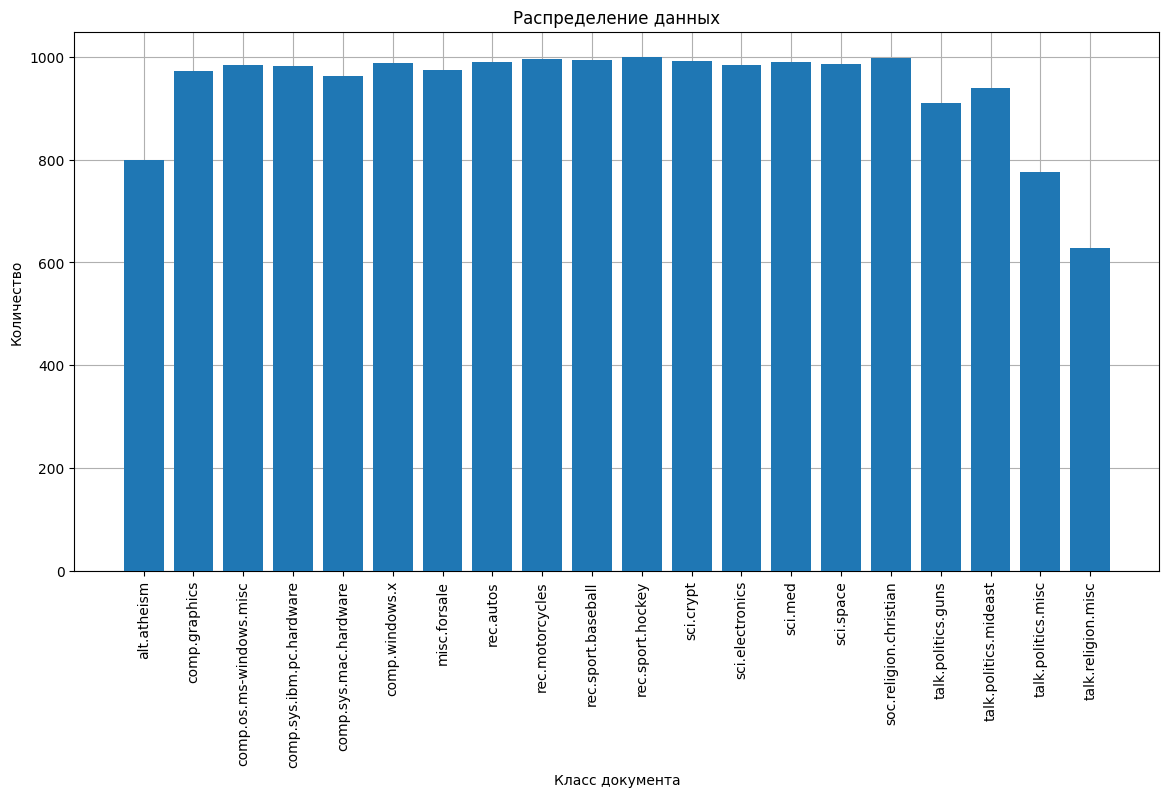

In [4]:
import matplotlib.pyplot as plt


# Построение графика распределения данных
# data - dataframe с данными
# дпредполагается что класс документа содержится в колонке Target
def showDistribution(data: pd.DataFrame, title: str) -> None:
    # Кол-во данных для каждого класса документов
    value_counts = data["Target"].value_counts()
    # Упорядочивание значений по классам
    value_counts = [value_counts[cls] for cls in range(0, CLS_COUNT)]

    plt.figure(figsize=(14, 7))
    plt.grid(zorder=0)

    plt.bar(target_names, value_counts, zorder=3)

    plt.title(title)
    plt.xlabel("Класс документа")
    plt.ylabel("Количество")

    plt.xticks(rotation=90)

    plt.show()


showDistribution(data, "Распределение данных")

---

**На тему религии документов в половину меньше от большинства остальных, но в целом датасет +- сбаласированный, доп операции для балансироваки проводится не будут**

---

**Семпл данных**

In [5]:
# Позволить pandas отображать длинные строки
pd.options.display.max_colwidth = 1000

data["Text"].sample(2, random_state=SEED)

18265    From: shippert@cco.caltech.edu (Tim Shippert)\nSubject: Re: Infield Fly Rule\nOrganization: California Institute of Technology, Pasadena\nLines: 25\nNNTP-Posting-Host: sandman.caltech.edu\n\njrogoff@scott.skidmore.edu (jay rogoff) writes:\n\n>One last infield fly question that has always puzzled me and hasn't\n>yet been addressed.  I believe the rule also does *not* deal with this\n>situation:\n\n>However, if the Infield Fly is *not* caught, at what point can a runner\n>legally leave his base w/o fear of being doubled off for advancing too\n>early?  \n\n\tThe runner can leave his base at any time.  If the ball is caught,\nhe's got to tag up.  If it isn't caught, he _doesn't_ have to tag up at\nall.  So, if he's feeling lucky, your runner at second can sprint for glory\nas soon as the ball is popped up.  If it isn't caught, he's probably scored\na run.  If it is, he's probably headed for AAA.  \n\n\tThe only effect the infield fly has is to make the batter out,\nthereby removin

---

**В каждом тексте присутвуют поля с доп данными о каждом тесксте (From, Subject и Lines, Organization и т.д.), так же данные засорены различными служебными симвлолами.**

---

### **Удаление доп данных в начале текста** 

In [6]:
import re


# Функция принимает:
# список полей fieldTitles - список ключевых слов с которых начинаются поля
# sep - сепаратор, символ окончания поля,
# в данном случае каждое поле в датасете заканчивается символом новой строки \n
# text - сам текст одного вхождения данных
def removeFields(text: str) -> str:

    # Выделение поля - набора символов алфоовита и цифр
    # а так же служебных символов . -
    regex = "[A-Za-z.-0-9]+:.*\n"
    # Удаление полдстроки/замена на пустую подстроку
    text = re.sub(regex, '', text)
    return text

In [7]:
# Выбор документа для примера
text = data["Text"].iloc[1]

fieldlessText = removeFields(text)

print(f"До: \n\n{text} \n\nПосле: \n\n{fieldlessText}")

До: 

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 


  My brother is in

### **Очистака от служебных символов = - + >> и т.д.**

In [8]:
# Функция принимает:
# text - текст одного вхождения данных
def specialCharacterCleaner(text: str) -> str:

    # Удаление апострофов используется для слов тиках как:
    # can't wouldn't и т.д.
    text = re.sub("'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("'s", " is", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'m", " am", text)

    # Выделение переходов на новую строку и дубликатов пробелов
    regex = "[\r\n\t\\s]+"
    # Замена выделенных подстрок на единый символ разделения ' '
    text = re.sub(regex, ' ', text)

    # Выделение пробела в начале строки
    regex = "^\\s"
    # замена на пустую строку
    text = re.sub(regex, '', text)

    # Удаление спецсимволов внутри слов
    resText = text[0]  # Отфильтрованная строка
    for i in range(1, len(text)):

        match text[i]:

            # Удаление спецсимволов являющихся частью слова
            # (считаю что если точка не в конце слова,
            # то является его частью например -
            # .net или shelley.u.washington.edu)
            case '.' | '-':

                nextIsLetter = False
                # Является ли текущий символ не последним в строке
                if i < len(text) - 1:
                    # Является ли след символ частью слова
                    nextIsLetter = text[i+1].isalpha()

                # Находится ли точка внутри слова
                if nextIsLetter:
                    # замена точки на разделение слов
                    resText += ' '
                else:
                    resText += text[i]

            # Любые иные символы записываются без изменений
            case _:
                resText += text[i]

    # Присвоение нового тескта
    text = resText
    # Удаление дубликата
    del resText

    # Выделение спецсимволов не являющихся символами пунктуации
    regex = "[^\\w 0-9.!?,]"
    # Замена на пустую строку
    text = re.sub(regex, '', text)

    # Замена двух и более точек одной
    # ... -> .
    regex = "[.]{2,}"  # Выделение подстрок из 2 и более точек
    text = re.sub(regex, '.', text)  # Замена на одну точку

    # Обрамление символов пунктуации пробелами
    # для послдеющего выделения их как отдельных слов - токенов
    text = re.sub('[.]', " . ", text)
    text = re.sub('[!]', " ! ", text)
    text = re.sub('[?]', " ? ", text)
    text = re.sub('[,]', " , ", text)

    # Замена дублиактов пробелов

    # Выделение подстрок состоящих из двух и более пробелов
    regex = " {2,}"
    # Замена выделенных подстрок на единичные пробелы
    text = re.sub(regex, ' ', text)
    return text

In [9]:
cleanText = specialCharacterCleaner(fieldlessText)

print(f"До: \n\n{fieldlessText} \n\nПосле: \n\n{cleanText}")

До: 


  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas 
  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 

My brother is in the market for a high performance video card that supports VESA local bus with 12MB RAM . Does anyone have suggestionsideas Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other high performance VLB card Please post or email . Thank you ! Matt Matthew B . Lawson mblawsonessex ecn uoknor edu No

### **Проверка орфоргафии**

In [10]:
from spellchecker import SpellChecker


# Примнимает лист слов words
# Лист слов с коррекциями если нужны
def spellCheck(words: list[str]) -> list[str]:

    # Загрузка спеллчекера
    spell = SpellChecker(language="en")

    # Корректировка слов
    # если слово распознано как несуществующее возвращается None
    correctedWords = [spell.correction(word) for word in words]
    # None исключается из текста
    correctedWords = [word for word in correctedWords if word is not None]
    return correctedWords

In [11]:
# Пример работы

testWords = ["Heloo", "neighbar", "abdfdc", "bye", "?"]

spellCheck(testWords)

['hello', 'neighbor', 'bye', '?']

### **Обработка данных**

---

**Построение пайплайна**

---

In [12]:
# Функция разбиения текста слова/токены
def splitText(text: str) -> list:
    return text.split()

In [13]:
cleanText

'My brother is in the market for a high performance video card that supports VESA local bus with 12MB RAM . Does anyone have suggestionsideas Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other high performance VLB card Please post or email . Thank you ! Matt Matthew B . Lawson mblawsonessex ecn uoknor edu Now I , Nebuchadnezzar , praise and exalt and glorify the King of heaven , because everything he does is right and all his ways are just . Nebuchadnezzar , king of Babylon , 562 B C . '

In [14]:
splitText(cleanText)[:10]

['My',
 'brother',
 'is',
 'in',
 'the',
 'market',
 'for',
 'a',
 'high',
 'performance']

In [15]:
from functools import reduce
from collections.abc import Callable


# Композиция нескольких функций
# fs - функции для составления композиции/пайплайна
def compose(*fs: tuple[Callable, ...]) -> Callable:

    # Композиция двух функций f, g
    # Возращаемый тип неизвестен, зависит от последней функции в композиции
    def compose2(f: Callable, g: Callable):
        return lambda x: f(g(x))

    # Построение самой композиции при помощи reduce
    composite_fn = reduce(compose2, fs, lambda x: x)
    return composite_fn


# Построение пайплайна для предобработки данных датасета
preprocessDataset = compose(spellCheck,
                            splitText,
                            specialCharacterCleaner,
                            removeFields)

In [16]:
prepd = preprocessDataset(text)

print(f"До: \n\n{text} \n\nПосле: \n\n{prepd}")

До: 

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   
 

После: 

['My', 'brother', '

### **Разбиение на выборки и их проверка на сбалансированность**

In [17]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data, test_size=0.2, random_state=SEED)

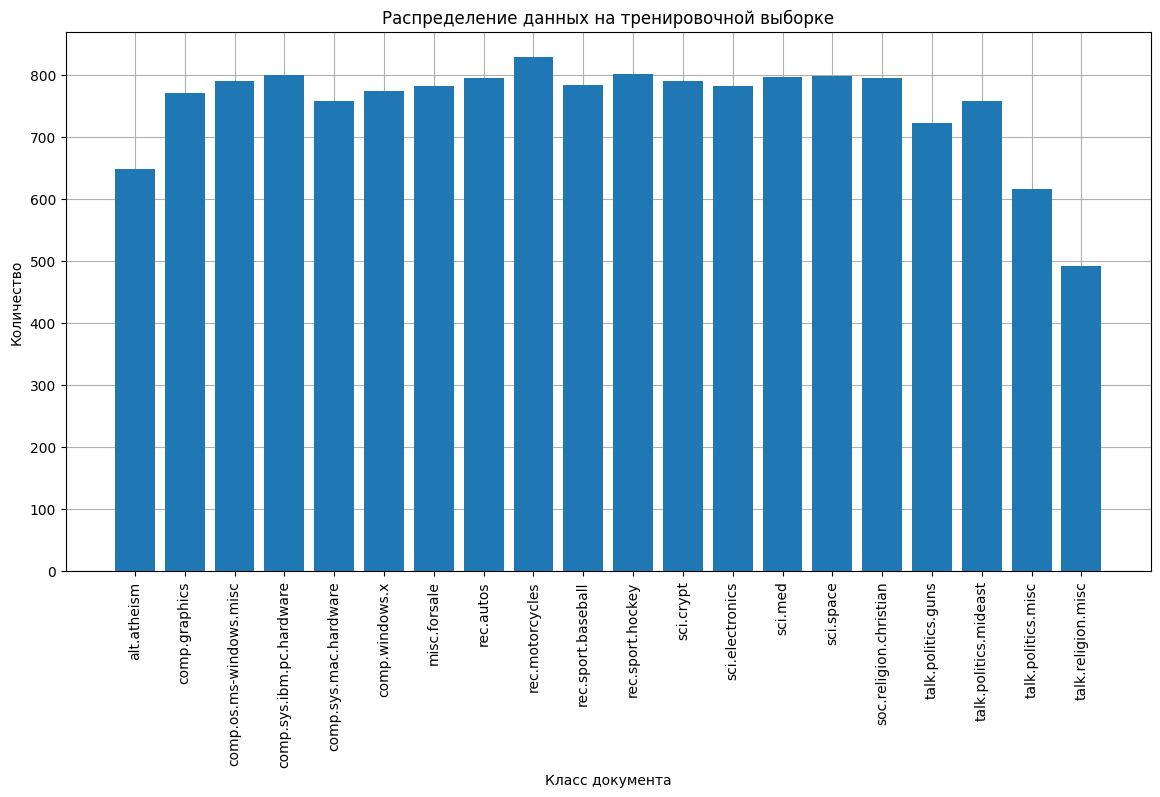

In [18]:
showDistribution(train, "Распределение данных на тренировочной выборке")

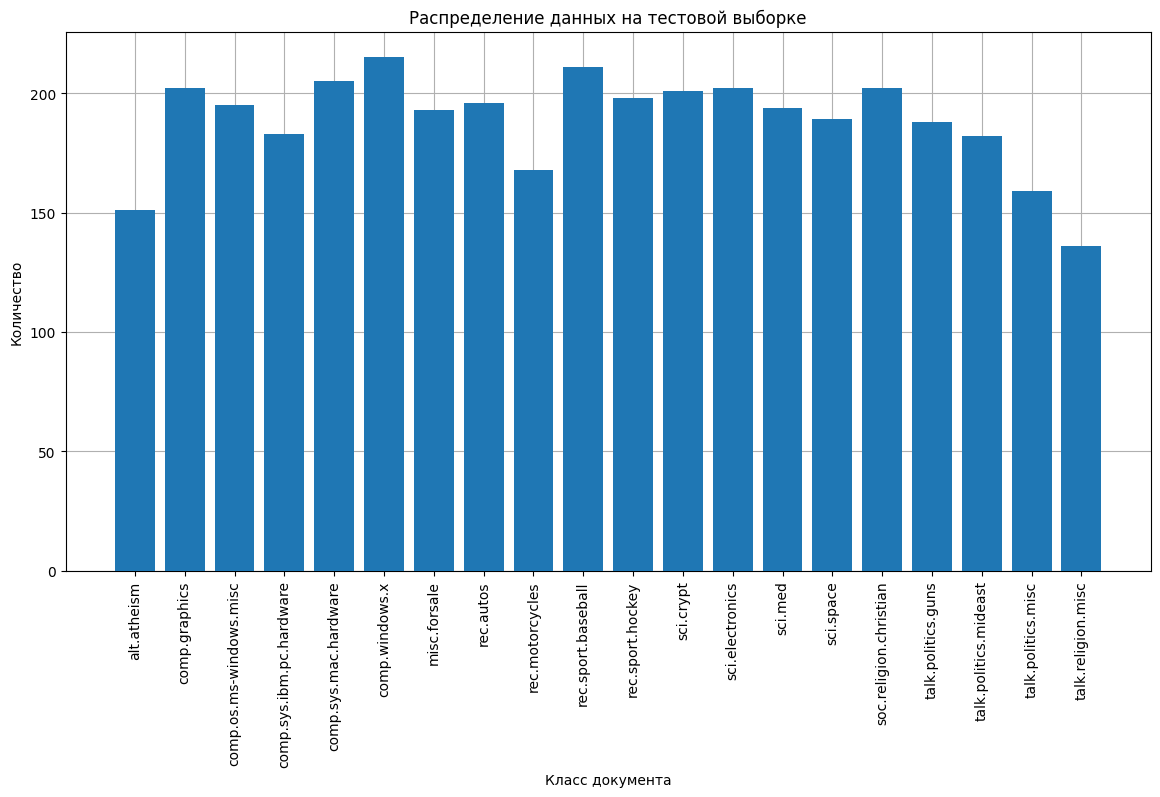

In [19]:
showDistribution(test, "Распределение данных на тестовой выборке")

## **Бейзлайн - модели классического ML над tf-idf**

### **tf-idf эмбеддинг**

In [20]:
# Объединение листа слов wordds в одну строку
# для последующей обработки tf-idf sklearn
def list2str(words: list[str]) -> str:
    return " ".join(words)

In [21]:
print(f"До: \n\n{prepd} \n\nПосле: \n\n{list2str(prepd)}")

До: 

['My', 'brother', 'is', 'in', 'the', 'market', 'for', 'a', 'high', 'performance', 'video', 'card', 'that', 'supports', 'vest', 'local', 'bus', 'with', 'bomb', 'RAM', '.', 'Does', 'anyone', 'have', 'Diamond', 'Stealth', 'Pro', 'Local', 'Bus', 'Orchid', 'fahrenheit', '1280', 'at', 'Graphics', 'Ultra', 'Pro', 'Any', 'other', 'high', 'performance', 'alb', 'card', 'Please', 'post', 'or', 'email', '.', 'Thank', 'you', '!', 'Matt', 'Matthew', 'B', '.', 'Lawson', 'en', 'honor', 'du', 'Now', 'I', ',', 'Nebuchadnezzar', ',', 'praise', 'and', 'exalt', 'and', 'glorify', 'the', 'King', 'of', 'heaven', ',', 'because', 'everything', 'he', 'does', 'is', 'right', 'and', 'all', 'his', 'ways', 'are', 'just', '.', 'Nebuchadnezzar', ',', 'king', 'of', 'Babylon', ',', '562', 'B', 'C', '.'] 

После: 

My brother is in the market for a high performance video card that supports vest local bus with bomb RAM . Does anyone have Diamond Stealth Pro Local Bus Orchid fahrenheit 1280 at Graphics Ultra Pro Any o